In [ ]:
"""
    Solving complex ordinary differential eqs.
    Found here: 
    https://stackoverflow.com/questions/19910189/scipy-odeint-with
    -complex-initial-values
"""

Maximum difference between the complex and real versions is


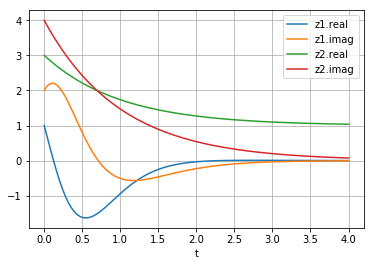

In [6]:
import numpy as np
from scipy.integrate import odeint


def odeintz(func, z0, t, **kwargs):
    """An odeint-like function for complex valued differential equations."""

    # Disallow Jacobian-related arguments.
    _unsupported_odeint_args = ['Dfun', 'col_deriv', 'ml', 'mu']
    bad_args = [arg for arg in kwargs if arg in _unsupported_odeint_args]
    if len(bad_args) > 0:
        raise ValueError("The odeint argument %r is not supported by "
                         "odeintz." % (bad_args[0],))

    # Make sure z0 is a numpy array of type np.complex128.
    z0 = np.array(z0, dtype=np.complex128, ndmin=1)

    def realfunc(x, t, *args):
        z = x.view(np.complex128)
        dzdt = func(z, t, *args)
        # func might return a python list, so convert its return
        # value to an array with type np.complex128, and then return
        # a np.float64 view of that array.
        return np.asarray(dzdt, dtype=np.complex128).view(np.float64)

    result = odeint(realfunc, z0.view(np.float64), t, **kwargs)

    if kwargs.get('full_output', False):
        z = result[0].view(np.complex128)
        infodict = result[1]
        return z, infodict
    else:
        z = result.view(np.complex128)
        return z


if __name__ == "__main__":
    # Generate a solution to:
    #     dz1/dt = -z1 * (K - z2)
    #     dz2/dt = L - z2
    # K and L are fixed parameters.  z1(t) and z2(t) are complex-
    # valued functions of t.

    # Define the right-hand-side of the differential equation.
    def zfunc(z, t, K, L):
        z1, z2 = z
        return [-z1 * (K - z2), L - z2] 

    # Set up the inputs and call odeintz to solve the system.
    z0 = np.array([1+2j, 3+4j])
    t = np.linspace(0, 4, 101)
    K = 3
    L = 1
    z, infodict = odeintz(zfunc, z0, t, args=(K,L), full_output=True)

    # For comparison, here is how the complex system can be converted
    # to a real system.  The real and imaginary parts are used to
    # write a system of four coupled equations.  The formulas for
    # the complex right-hand-sides are
    #   -z1 * (K - z2) = -(x1 + i*y1) * (K - (x2 + i*y2))
    #                  = (-x1 - i*y1) * (K - x2 + i(-y2))
    #                  = -x1 * (K - x2) - y1*y2 + i*(-y1*(K - x2) + x1*y2)
    # and
    #   L - z2 = L - (x2 + i*y2)
    #          = (L - x2) + i*(-y2)
    def func(r, t, K, L):
        x1, y1, x2, y2 = r
        dx1dt = -x1 * (K - x2) - y1*y2
        dy1dt = -y1 * (K - x2) + x1*y2
        dx2dt = L - x2
        dy2dt = -y2
        return [dx1dt, dy1dt, dx2dt, dy2dt]

    # Use regular odeint to solve the real system.
    r, infodict = odeint(func, z0.view(np.float64), t, args=(K,L), full_output=True)

    # Compare the two solutions.  They should be the same.  (As usual for
    # floating point calculations, there could be a small difference.)
    delta_max = np.abs(z.view(np.float64) - r).max()
    print ("Maximum difference between the complex and real versions is"), delta_max


    # Plot the real and imaginary parts of the complex solution.

    import matplotlib.pyplot as plt

    plt.clf()
    plt.plot(t, z[:,0].real, label='z1.real')
    plt.plot(t, z[:,0].imag, label='z1.imag')
    plt.plot(t, z[:,1].real, label='z2.real')
    plt.plot(t, z[:,1].imag, label='z2.imag')
    plt.xlabel('t')
    plt.grid(True)
    plt.legend(loc='best')
    plt.show()